# **Packages Used**

In [1]:
import numpy as np
import pandas as pd
from google.colab import files
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.pipeline import Pipeline

In [2]:
import spacy
spacy.prefer_gpu()
sp=spacy.load('en_core_web_sm', disable = ['ner'])

# **Data Preprocessing and ML Model Generation**

In [3]:
df = pd.read_csv('https://zenodo.org/record/5550238/files/osdg-community-dataset-v21-09-30.csv?download=1')
df.head()

,doi,text_id,text,sdg,labels_negative,labels_positive,agreement
0,10.6027/9789289342698-7-en,00021941702cd84171ff33962197ca1f,"From a gender perspective, Paulgaard points ou...",5,1,7,0.750000
1,10.18356/eca72908-en,00028349a7f9b2485ff344ae44ccfd6b,Labour legislation regulates maximum working h...,11,2,1,0.333333
2,10.1787/9789264289062-4-en,0004eb64f96e1620cd852603d9cbe4d4,The average figure also masks large difference...,3,1,6,0.714286
3,10.1787/5k9b7bn5qzvd-en,0006a887475ccfa5a7f5f51d4ac83d02,The extent to which they are akin to corruptio...,3,1,2,0.333333
4,10.1787/9789264258211-6-en,0006d6e7593776abbdf4a6f985ea6d95,A region reporting a higher rate will not earn...,3,2,2,0.000000


### **Data Preprocessing**

In [4]:
df=df[df['agreement']>0.5]
df=df.drop(columns=['doi','text_id','labels_negative','labels_positive','agreement'])
df.head()

,text,sdg
0,"From a gender perspective, Paulgaard points ou...",5
2,The average figure also masks large difference...,3
7,The Israel Oceanographic and Limnological Rese...,6
8,Previous chapters have discussed ways to make ...,2
11,Prescription rates appear to be higher where l...,8


In [5]:
def required_pos_extractor(string_list): 
    pos_values=list()
    for text_values in tqdm(sp.pipe(string_list,batch_size=256)):
        tokens=list()
        for token in text_values:
            if token.pos_ in ['NOUN', 'VERB', 'ADJ']:
                tokens.append(token.lemma_)
        pos_values.append(' '.join(tokens))
    return pos_values

In [6]:
df['imp_words']=required_pos_extractor(df['text'].values)
df=df.drop(columns=['text'])
df.head()

19726it [01:21, 243.23it/s]


,sdg,imp_words
0,5,gender perspective point labour market fishing...
2,3,average figure mask large difference region nu...
7,6,station monitor quantity quality water coastli...
8,2,previous chapter discuss way make food system ...
11,8,prescription rate appear high labour force par...


### **Building the model**

In [7]:
# Preparing the data for training
x_train,x_test,y_train,y_test=train_test_split(df['imp_words'].values,df['sdg'].values)

# Creating an ML pipeline for training the data and building the model for predictions
# The model that is created is a Multinomial Logistic Regression Model with Cross Validations. 

pipe = Pipeline([
    ('vectoriser',TfidfVectorizer(ngram_range=(1,2),max_df = 0.75,min_df = 2,max_features = 100_000)),
    ('selector',SelectKBest(f_classif,k = 5_000)),
    ('clf',LogisticRegressionCV(penalty='l2',multi_class='multinomial',class_weight='balanced',random_state=42,solver='newton-cg',cv=5,max_iter=100))])


In [8]:
pipe.fit(x_train,y_train)

Pipeline(steps=[('vectoriser',
                 TfidfVectorizer(max_df=0.75, max_features=100000, min_df=2,
                                 ngram_range=(1, 2))),
                ('selector', SelectKBest(k=5000)),
                ('clf',
                 LogisticRegressionCV(class_weight='balanced', cv=5,
                                      multi_class='multinomial',
                                      random_state=42, solver='newton-cg'))])

In [9]:
predictions=pipe.predict(x_test)
print('Predictions: '+str(predictions))
print('Actuals: '+str(y_test))
print(classification_report(y_test,predictions))

Predictions: [ 5  4  6 ...  8 14  6]
Actuals: [ 5  4  6 ...  4 14  6]
              precision    recall  f1-score   support

           1       0.81      0.70      0.75       353
           2       0.72      0.79      0.75       270
           3       0.87      0.88      0.87       476
           4       0.90      0.86      0.88       661
           5       0.89      0.81      0.85       737
           6       0.88      0.78      0.83       396
           7       0.87      0.81      0.84       445
           8       0.47      0.57      0.52       224
           9       0.55      0.79      0.65       191
          10       0.41      0.53      0.46       126
          11       0.79      0.80      0.79       318
          12       0.55      0.73      0.63        66
          13       0.83      0.81      0.82       324
          14       0.88      0.87      0.87       205
          15       0.74      0.78      0.76       140

    accuracy                           0.79      4932
   macro a

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


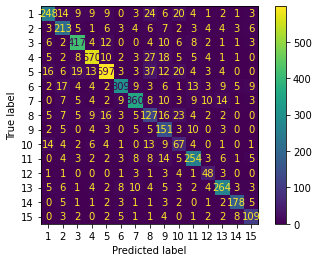

In [10]:
plot_confusion_matrix(pipe,x_test,y_test)

# **Real Application**

In [37]:
# Only text files: 
data=files.upload()
for t in data:
  data=data.get(t)
data=str(data)
print(data)

Saving 5554-19_CSR.pdf to 5554-19_CSR (1).pdf
b'%PDF-1.7\r\n%\xb5\xb5\xb5\xb5\r\n1 0 obj\r\n<</Type/Catalog/Pages 2 0 R/Lang(en-IN) /StructTreeRoot 39 0 R/MarkInfo<</Marked true>>/Metadata 678 0 R/ViewerPreferences 679 0 R>>\r\nendobj\r\n2 0 obj\r\n<</Type/Pages/Count 13/Kids[ 3 0 R 14 0 R 16 0 R 18 0 R 20 0 R 22 0 R 24 0 R 26 0 R 28 0 R 30 0 R 32 0 R 34 0 R 36 0 R] >>\r\nendobj\r\n3 0 obj\r\n<</Type/Page/Parent 2 0 R/Resources<</Font<</F1 5 0 R/F2 9 0 R>>/ExtGState<</GS7 7 0 R/GS8 8 0 R>>/ProcSet[/PDF/Text/ImageB/ImageC/ImageI] >>/MediaBox[ 0 0 595.32 841.92] /Contents 4 0 R/Group<</Type/Group/S/Transparency/CS/DeviceRGB>>/Tabs/S/StructParents 0>>\r\nendobj\r\n4 0 obj\r\n<</Filter/FlateDecode/Length 3571>>\r\nstream\r\nx\x9c\xbd\\[o\xdb:\x12~\x0f\x90\xff\xa0\xc7x\xd1\xb2\xa2D\xea\x02\x14\x05\x127)\xba\xd8\x9e\xd3M\x0c\xec.N\xf7\xc1\xb78n|;\x96\x934\xff~9C\r)Yb\x94\xd3\xa5\xda\x07\xd5\xb1D\x91\x1c\x0eg\xbe\xf9f\xe8\xe0\xdd\xd7\xe0\xfd\xfbw_\x86\x9f?\x06\xe1\x87\x0f\xc1\xc5\xc7a\xf0\xe7

In [38]:
text_pos=required_pos_extractor(data)

271187it [03:31, 1281.70it/s]


In [39]:
new_pred=pipe.predict(text_pos)

In [40]:
print('The sustainability development goal satisfied by this company: '+str(np.unique(new_pred)))

The sustainability development goal satisfied by this company: [2]
